In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Feature Preperation

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final_Cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_vote'] > 0).astype(int)

In [4]:
# Define features and target
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
                      'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']
target = 'helpful'



# Initialize X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features)  # Scale numerical features
    ],
    remainder='passthrough'  # Keep all other columns in the DataFrame
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=features)


# 2 Train/Test Split with Stratified K-Fold Cross-validation for Unbalanced Dataset

In [5]:
## Perform stratified K-fold cross-validation for classification with a combined stratification column 'stratify' to ensure balanced class distribution in each fold
# This column is created by combining 'helpful' and 'Prod' columns as strings.
# It uses StratifiedKFold with 10 splits, ensuring each fold preserves the percentage of samples for each class label (product and helpfulness).

from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (16338, 14)
X_test shape: (1816, 14)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840678
1    0.159322
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840308
1    0.159692
Name: proportion, dtype: float64
X_train shape: (16338, 14)
X_test shape: (1816, 14)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840617
1    0.159383
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840859
1    0.159141
Name: proportion, dtype: float64
X_train shape: (16338, 14)
X_test shape: (1816, 14)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840678
1    0.159322
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840308
1    0.159692
Name: proportion, dtype: float64
X_train shape: (16338, 14)
X_test shape: (1816, 14)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify di

## 2.1 Data Augmentation 

In [6]:
# Applying SMOTE to the training data to ensure balanced class distribution

from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Check the class distribution before resampling
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
helpful
0    13736
1     2603
Name: count, dtype: int64
Class distribution after SMOTE:
helpful
0    13736
1     8000
Name: count, dtype: int64


# 3. Model Building 

## 3.1 Logistic Regression

In [7]:
#Using Logistic Regression as Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='sag', max_iter=1000)  # You can adjust max_iter as needed

# Train the model
logreg_model.fit(X_train_balanced, y_train_balanced)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Model Evaluation:")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

LR_results = pd.DataFrame(results_dict)


Logistic Regression Model Evaluation:
Accuracy: 0.768595041322314
F1 Score: 0.4034090909090909
AUC: 0.6556472583380442
              precision    recall  f1-score   support

           0       0.89      0.82      0.86      1525
           1       0.34      0.49      0.40       290

    accuracy                           0.77      1815
   macro avg       0.62      0.66      0.63      1815
weighted avg       0.81      0.77      0.78      1815

[[1253  272]
 [ 148  142]]


## 3.2 Random Forest

In [8]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
RF_model = RandomForestClassifier()  # You can adjust max_iter as needed

# Train the model
RF_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = RF_model.predict(X_test)


print("\nRandom Forest Model Evaluation:")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)





Random Forest Model Evaluation:
Accuracy: 0.8589531680440772
F1 Score: 0.350253807106599
AUC: 0.6074901074053136
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1525
           1       0.66      0.24      0.35       290

    accuracy                           0.86      1815
   macro avg       0.77      0.61      0.64      1815
weighted avg       0.84      0.86      0.83      1815

[[1490   35]
 [ 221   69]]


## 3.2 Extreme Gradient Boosting

In [9]:
# Starting of with unbalanced data (No SMOTE applied) to evaluate improvement due to SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault XGBoost Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost Default'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Default_results = pd.DataFrame(results_dict)



Default XGBoost Evaluation:
Accuracy: 0.8633608815426997
F1 Score: 0.45614035087719296
AUC: 0.6589824759751273
Confusion Matrix:
[[1463   62]
 [ 186  104]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1525
           1       0.63      0.36      0.46       290

    accuracy                           0.86      1815
   macro avg       0.76      0.66      0.69      1815
weighted avg       0.85      0.86      0.85      1815

Mean Cross-Validated Accuracy: 0.813636195042671


In [10]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_SMOTE = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_SMOTE)
conf_matrix = confusion_matrix(y_test, y_pred_SMOTE)
cls_report = classification_report(y_test, y_pred_SMOTE)

print("\SMOTE Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_SMOTE)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_SMOTE)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost SMOTE'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_results = pd.DataFrame(results_dict)

\SMOTE Model Evaluation:
Accuracy: 0.8523415977961433
F1 Score: 0.4745098039215686
AUC: 0.6761616732617298
Confusion Matrix:
[[1426   99]
 [ 169  121]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1525
           1       0.55      0.42      0.47       290

    accuracy                           0.85      1815
   macro avg       0.72      0.68      0.69      1815
weighted avg       0.84      0.85      0.84      1815

Mean Cross-Validated Accuracy: 0.8024107183860794


### 3.2.1 XGradBoost Hyperparameter Tuning

In [11]:
# import packages for hyperparameters tuning with hyperopt (Bayesian Optimization)

# Define Search Space for hyperparameters
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'seed': 0
    }

# Define the objective function, objective function: Takes space as input (hyperparameters to optimize). Returns loss to minimize
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = int(space['gamma']),
                    reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [12]:
# Running Bayesian Optimization

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.8517906336088155                                     
  1%|          | 1/100 [00:00<00:13,  7.49trial/s, best loss: -0.8517906336088155]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8567493112947658                                                                
SCORE:                                                                            
0.8512396694214877                                                                
SCORE:                                                                            
0.8539944903581267                                                                
  4%|▍         | 4/100 [00:00<00:09, 10.20trial/s, best loss: -0.8567493112947658]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8539944903581267                                                                
SCORE:                                                                            
0.8501377410468319                                                                
SCORE:                                                                            
0.8545454545454545                                                                
  6%|▌         | 6/100 [00:00<00:08, 10.89trial/s, best loss: -0.8567493112947658]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8606060606060606                                                                
SCORE:                                                                            
0.8440771349862259                                                                
SCORE:                                                                            
0.8539944903581267                                                                
 10%|█         | 10/100 [00:00<00:08, 11.17trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8473829201101928                                                                 
SCORE:                                                                             
0.8534435261707989                                                                 
 12%|█▏        | 12/100 [00:01<00:10,  8.62trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8506887052341597                                                                 
SCORE:                                                                             
0.8495867768595041                                                                 
 14%|█▍        | 14/100 [00:01<00:09,  9.53trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
SCORE:                                                                             
0.8501377410468319                                                                 
SCORE:                                                                             
0.8418732782369146                                                                 
 16%|█▌        | 16/100 [00:01<00:08, 10.15trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8418732782369146                                                                 
SCORE:                                                                             
0.846831955922865                                                                  
 18%|█▊        | 18/100 [00:01<00:07, 10.52trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8556473829201102                                                                 
SCORE:                                                                             
0.8495867768595041                                                                 
 20%|██        | 20/100 [00:02<00:08,  9.27trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8517906336088155                                                                 
SCORE:                                                                             
0.8545454545454545                                                                 
SCORE:                                                                             


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8501377410468319
SCORE:                                                                             
0.8479338842975207                                                                 
SCORE:                                                                             
0.8495867768595041                                                                 
 26%|██▌       | 26/100 [00:02<00:07, 10.20trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8523415977961433                                                                 
SCORE:                                                                             
0.856198347107438                                                                  
 28%|██▊       | 28/100 [00:02<00:07, 10.09trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.843526170798898                                                                  
SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
                                                                                   

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8545454545454545
SCORE:                                                                             
0.8539944903581267                                                                 
 32%|███▏      | 32/100 [00:03<00:08,  8.21trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8479338842975207                                                                 
SCORE:                                                                             
0.859504132231405                                                                  
 34%|███▍      | 34/100 [00:03<00:09,  7.17trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8573002754820936                                                                 
SCORE:                                                                             
0.8528925619834711                                                                 
 36%|███▌      | 36/100 [00:03<00:08,  7.72trial/s, best loss: -0.8606060606060606]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8611570247933884                                                                 
SCORE:                                                                             
0.8539944903581267                                                                 
 38%|███▊      | 38/100 [00:04<00:08,  7.72trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8550964187327824                                                                 
SCORE:                                                                             
0.8506887052341597                                                                 
SCORE:                                                                             
0.8539944903581267                                                                 
 41%|████      | 41/100 [00:04<00:06,  8.64trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.856198347107438                                                                  
SCORE:                                                                             
0.8506887052341597                                                                 
SCORE:                                                                             
0.8545454545454545                                                                 
 44%|████▍     | 44/100 [00:04<00:06,  9.04trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8512396694214877                                                                 
SCORE:                                                                             
0.8534435261707989                                                                 
SCORE:                                                                             
0.8429752066115702                                                                 
 46%|████▌     | 46/100 [00:05<00:05, 10.12trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.856198347107438                                                                  
SCORE:                                                                             
0.8473829201101928                                                                 
 48%|████▊     | 48/100 [00:05<00:05, 10.33trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8550964187327824                                                                 
SCORE:                                                                             
0.8440771349862259                                                                 
SCORE:                                                                             
0.8484848484848485                                                                 
 52%|█████▏    | 52/100 [00:05<00:04,  9.87trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8473829201101928                                                                 
SCORE:                                                                             
0.8429752066115702                                                                 
 54%|█████▍    | 54/100 [00:05<00:04,  9.82trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.843526170798898                                                                  
SCORE:                                                                             
0.8517906336088155                                                                 
SCORE:                                                                             
0.8517906336088155                                                                 
 56%|█████▌    | 56/100 [00:06<00:04,  9.04trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8550964187327824                                                                 
SCORE:                                                                             
0.8539944903581267                                                                 
 59%|█████▉    | 59/100 [00:06<00:04,  8.44trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8517906336088155                                                                 
SCORE:                                                                             
0.8573002754820936                                                                 
SCORE:                                                                             
0.8490358126721763                                                                 
 62%|██████▏   | 62/100 [00:06<00:03,  9.92trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8573002754820936                                                                 
SCORE:                                                                             
0.8473829201101928                                                                 
 64%|██████▍   | 64/100 [00:06<00:03, 10.20trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.859504132231405                                                                  
SCORE:                                                                             
0.859504132231405                                                                  
 66%|██████▌   | 66/100 [00:07<00:03,  9.20trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8567493112947658                                                                 
SCORE:                                                                             
0.8528925619834711                                                                 
SCORE:                                                                             
0.8534435261707989                                                                 
 69%|██████▉   | 69/100 [00:07<00:03,  9.38trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8567493112947658                                                                 
SCORE:                                                                             
0.8573002754820936                                                                 
SCORE:                                                                             
0.8462809917355372                                                                 
 71%|███████   | 71/100 [00:07<00:03,  8.12trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
SCORE:                                                                             
 73%|███████▎  | 73/100 [00:08<00:03,  8.85trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8501377410468319                                                                 
SCORE:                                                                             
0.8501377410468319                                                                 
SCORE:                                                                             
0.856198347107438                                                                  
 76%|███████▌  | 76/100 [00:08<00:02,  9.60trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8523415977961433                                                                 
SCORE:                                                                             
0.8611570247933884                                                                 
 78%|███████▊  | 78/100 [00:08<00:02,  9.58trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8573002754820936                                                                 
SCORE:                                                                             
0.8534435261707989                                                                 
SCORE:                                                                             
0.8484848484848485                                                                 
 80%|████████  | 80/100 [00:08<00:02,  7.52trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8418732782369146                                                                 
SCORE:                                                                             
0.8473829201101928                                                                 
SCORE:                                                                             
0.8578512396694215                                                                 
 83%|████████▎ | 83/100 [00:09<00:02,  7.52trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8539944903581267                                                                 
 85%|████████▌ | 85/100 [00:09<00:01,  8.11trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8606060606060606                                                                 
SCORE:                                                                             
0.8523415977961433                                                                 
SCORE:                                                                             
0.856198347107438                                                                  
 87%|████████▋ | 87/100 [00:09<00:01,  8.92trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8523415977961433                                                                 
SCORE:                                                                             
0.8523415977961433                                                                 
 90%|█████████ | 90/100 [00:09<00:01,  8.80trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8490358126721763                                                                 
SCORE:                                                                             
0.8479338842975207                                                                 
 92%|█████████▏| 92/100 [00:10<00:00,  8.24trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8479338842975207                                                                 
SCORE:                                                                             
0.8539944903581267                                                                 
SCORE:                                                                             
0.8523415977961433                                                                 
 95%|█████████▌| 95/100 [00:10<00:00,  9.42trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8495867768595041                                                                 
SCORE:                                                                             
0.8484848484848485                                                                 
 97%|█████████▋| 97/100 [00:10<00:00,  8.53trial/s, best loss: -0.8611570247933884]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
SCORE:                                                                             
0.8573002754820936                                                                 
SCORE:                                                                             
0.8517906336088155                                                                 
100%|██████████| 100/100 [00:11<00:00,  9.02trial/s, best loss: -0.8611570247933884]
The best hyperparameters are :  

{'colsample_bytree': 0.45385355941952416, 'gamma': 2.4060615573515274, 'max_depth': 7.0, 'min_child_weight': 6.0, 'n_estimators': 300.0, 'reg_lambda': 2.175532385976583}


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [13]:
# Save the best hyperparameters in a dictionary
best_hyperparams={'colsample_bytree': 0.7716761454118004, 'gamma': 1.9708066405788685, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 150, 'reg_lambda': 8.695328541345564}



In [14]:
# With considering inbalanced data applying Weighted XGBoost
# Calculate class distribution

from collections import Counter
sqrt = np.sqrt

# Count the class distribution in the training set
counts = y_train_balanced.value_counts()
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = int(sqrt(count_of_zeros /count_of_ones))

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: helpful
0    13736
1     8000
Name: count, dtype: int64
scale_pos_weight: 1


In [15]:
# Train model with modified hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
cls_report = classification_report(y_test, y_pred_opt)

print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_opt)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost with Hyperparameters'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Hyp_results = pd.DataFrame(results_dict)


SMOTE-Hyp Model Evaluation:
Accuracy: 0.8556473829201102
F1 Score: 0.5019011406844107
AUC: 0.693487846240814
Confusion Matrix:
[[1421  104]
 [ 158  132]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1525
           1       0.56      0.46      0.50       290

    accuracy                           0.86      1815
   macro avg       0.73      0.69      0.71      1815
weighted avg       0.85      0.86      0.85      1815

Mean Cross-Validated Accuracy: 0.787596115203011


# 4. Model Comparision

In [16]:
results = pd.concat([LR_results, XGB_Default_results, XGB_results, XGB_Hyp_results], axis=0)
print(results)

                          Model  Accuracy  F1 Score       AUC
0           Logistic Regression  0.768595  0.403409  0.655647
0               XGBoost Default  0.863361  0.456140  0.658982
0                 XGBoost SMOTE  0.852342  0.474510  0.676162
0  XGBoost with Hyperparameters  0.855647  0.501901  0.693488




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



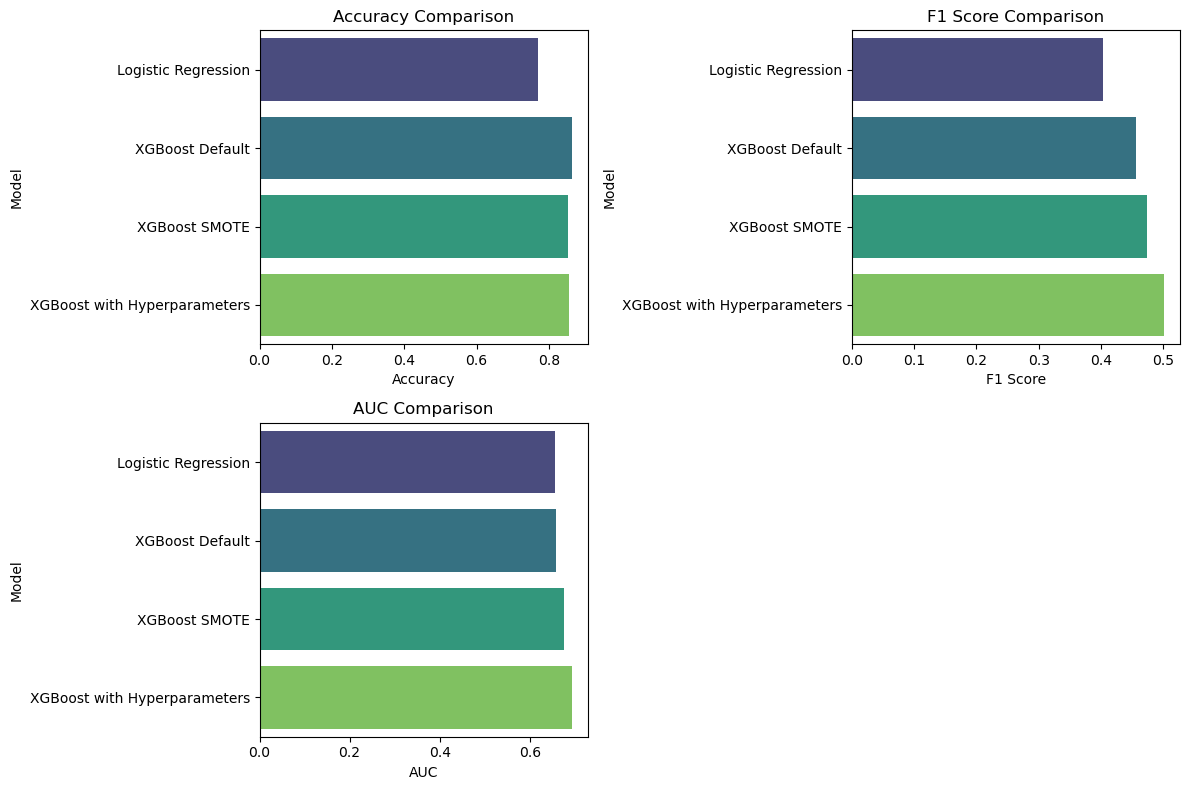

In [17]:
# Plotting the comparison
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')

# Plot 2: F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='F1 Score', y='Model', data=results, palette='viridis')
plt.title('F1 Score Comparison')
plt.xlabel('F1 Score')

# Plot 3: AUC
plt.subplot(2, 2, 3)
sns.barplot(x='AUC', y='Model', data=results, palette='viridis')
plt.title('AUC Comparison')
plt.xlabel('AUC')

plt.tight_layout()
plt.show()

# 5. Feature Importance with Shap Values

[11:52:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 21382/21736 [00:21<00:00]        

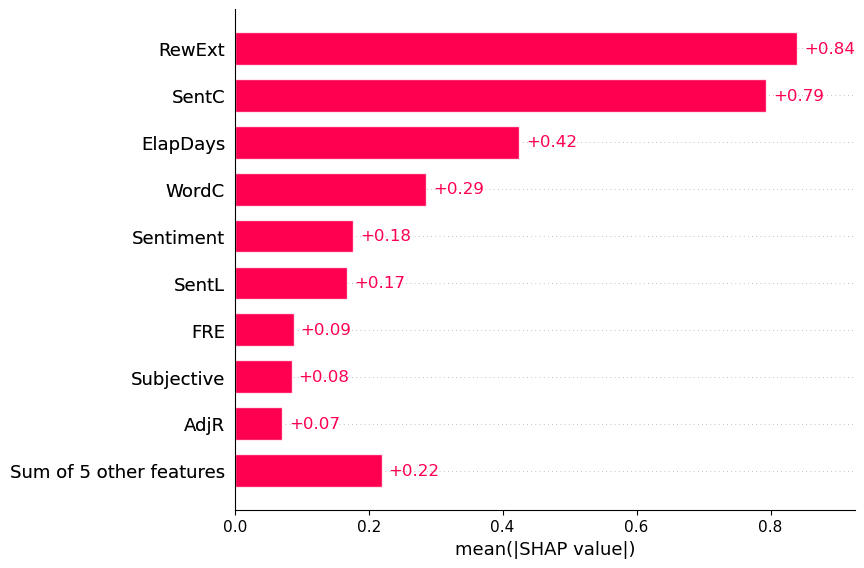

In [18]:
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.bar(shap_values.abs.mean(0))

[11:53:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 95%|=================== | 20737/21736 [00:20<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


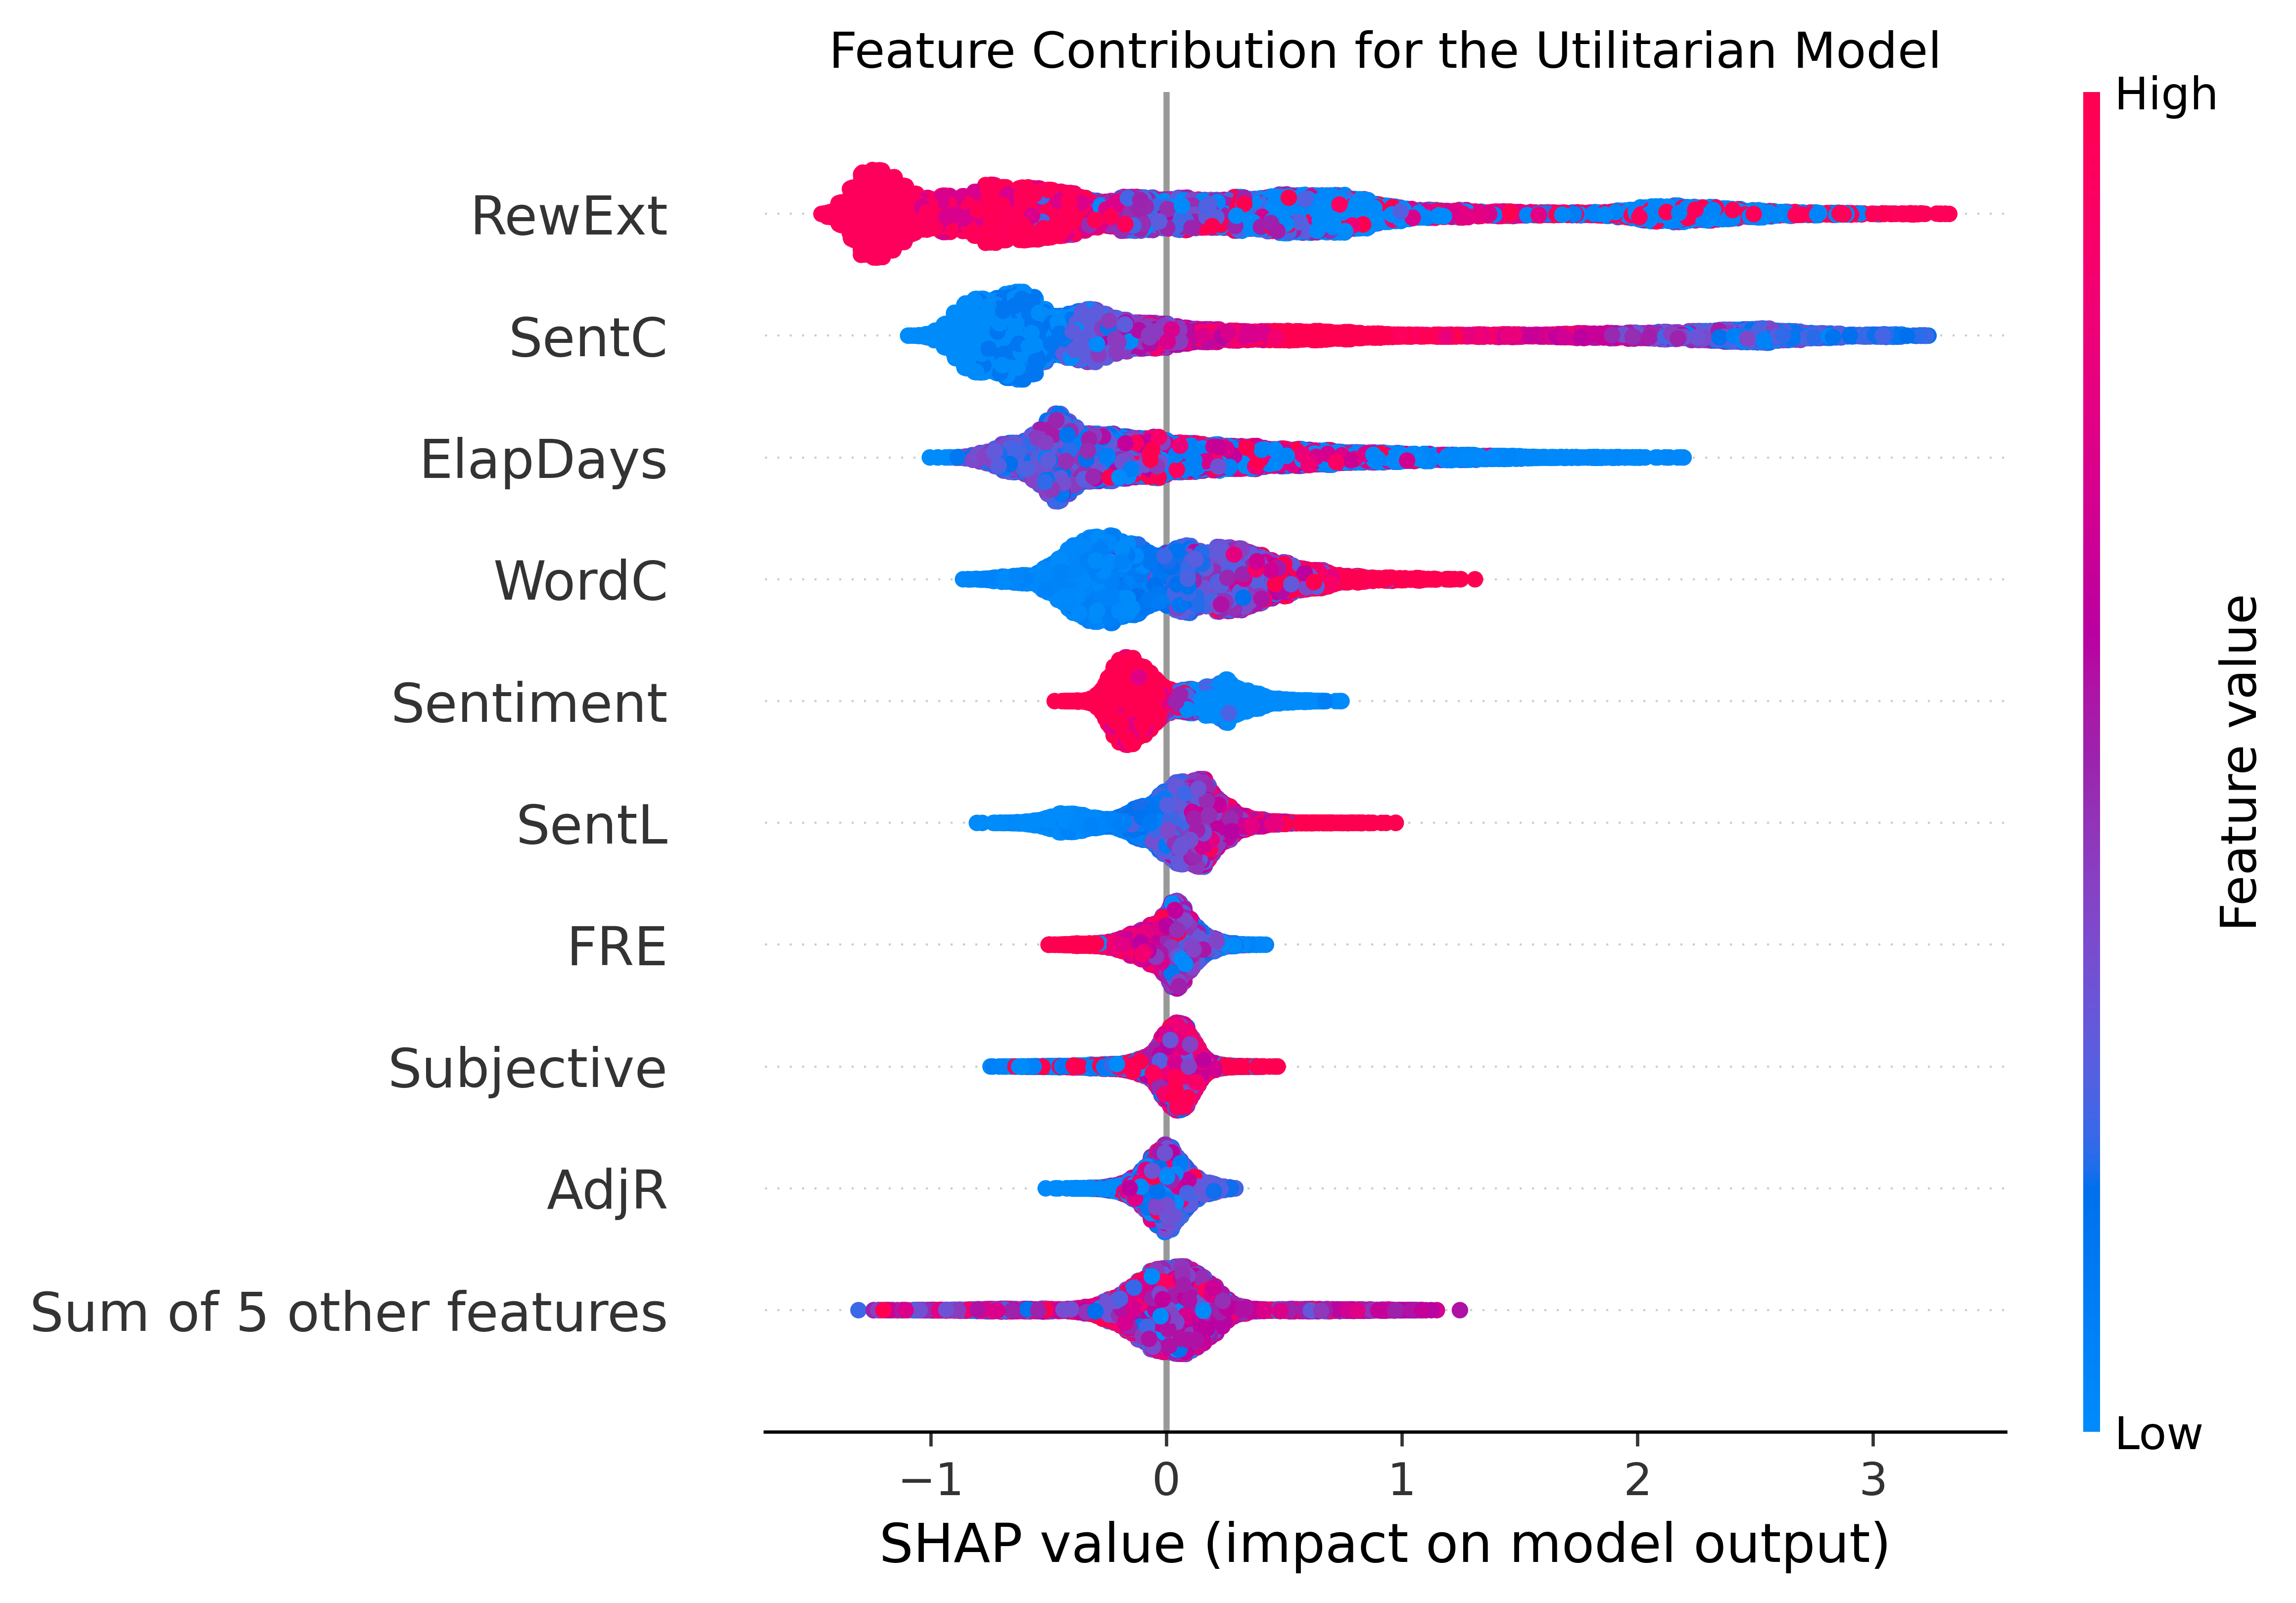

In [19]:
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

# Create a beeswarm plot with increased quality
fig, ax = plt.subplots(figsize=(12, 8), dpi=600)  # Set figure size and DPI
shap.plots.beeswarm(shap_values, max_display=10, show=False)  # Create the plot without displaying it immediately

# Add title to the plot
plt.title('Feature Contribution for the Utilitarian Model')

plt.tight_layout()  # Adjust the layout to prevent clipping

# Save the plot to a file with high resolution
plt.savefig('shap_beeswarm_plot_Utilitarian.png', dpi=600)  # Save the figure with the desired DPI

# Display the plot
plt.show()

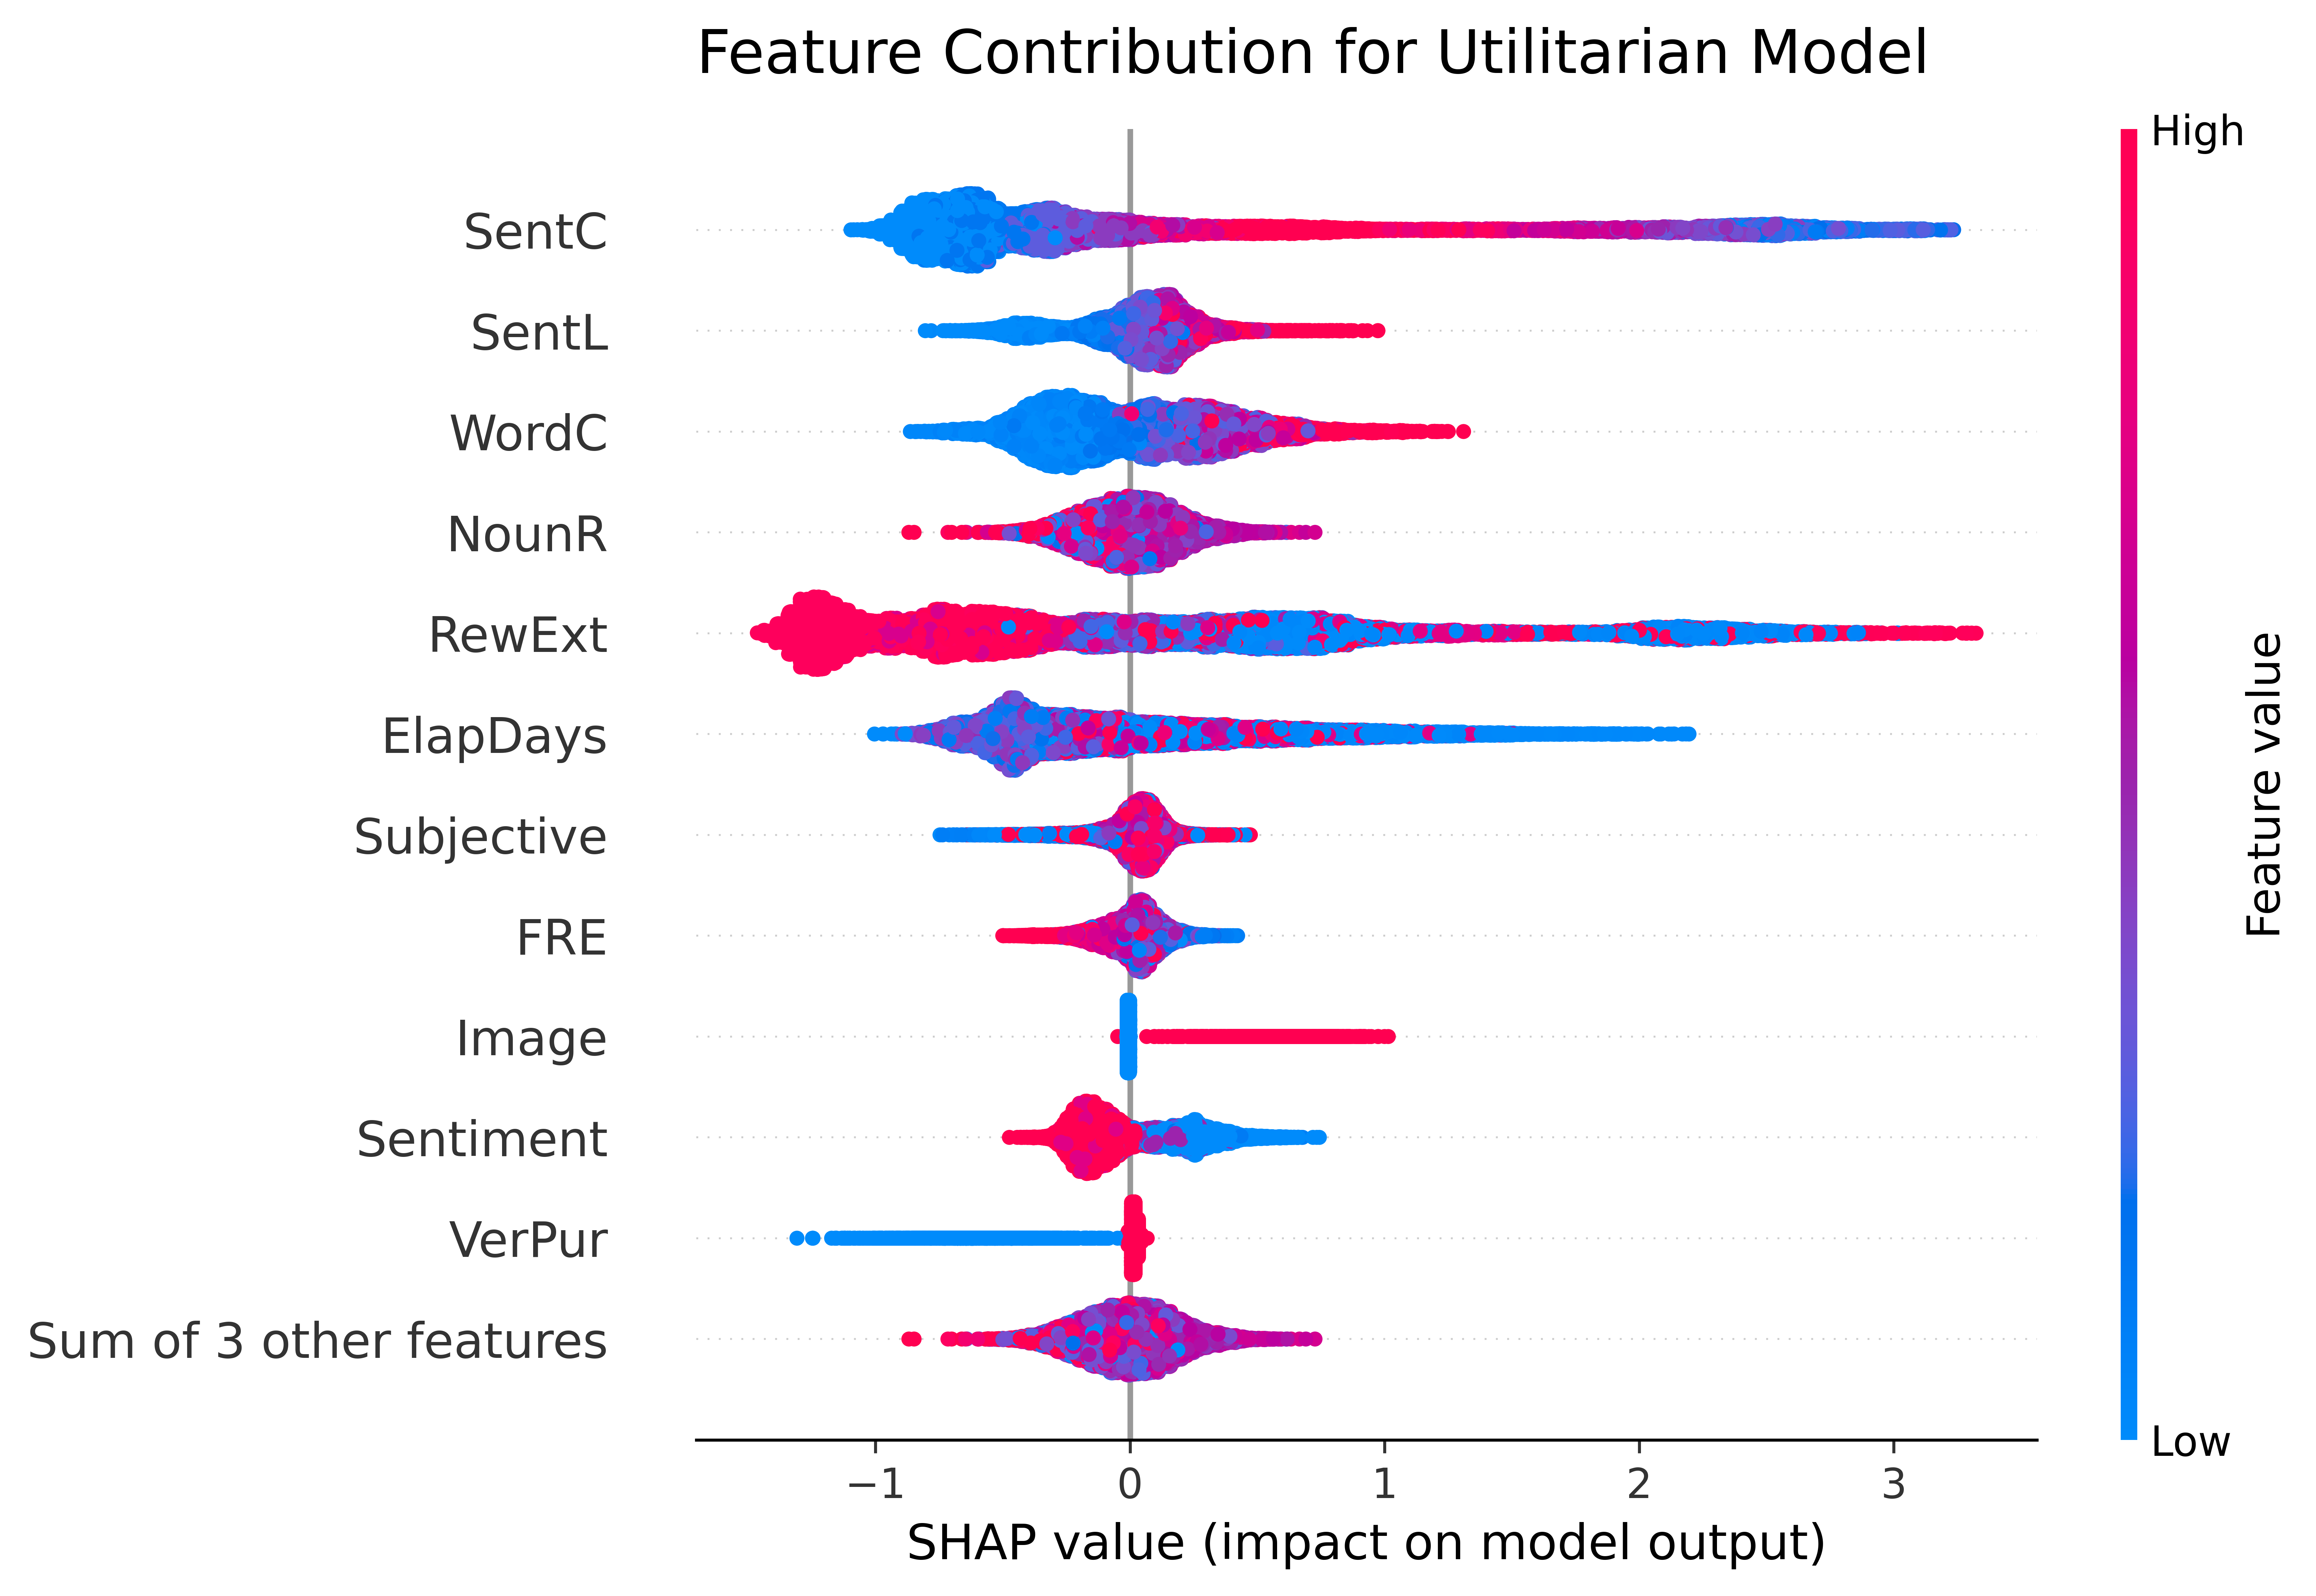

In [20]:
# Define the order of the features
order = [
    "SentC",
    "SentL",
    "WordC",
    "NounR",
    "RewExt",
    "ElapDays",
    "Subjective",
    "FRE",
    "Image",
    "Sentiment",
    'VerPur', 
    'NounR', 
    'AdjR', 
    'AdvR',
]

# Create a mapping from column names to their indices
col2num = {col: i for i, col in enumerate(X_train_balanced.columns)}

# Ensure all columns in order exist in the DataFrame and map them to their indices
order = [col2num[col] for col in order if col in col2num]

# Create the beeswarm plot with the correct order
fig, ax = plt.subplots(figsize=(12, 8), dpi=800)  # Set figure size and DPI
shap.plots.beeswarm(shap_values, max_display=12, show=False, order=order)  # Create the plot without displaying it immediately


# Add title to the plot
plt.title('Feature Contribution for Utilitarian Model',fontsize=16,loc='left',pad=15)

# Save the plot to a file with high resolution
plt.savefig('shap_beeswarm_plot_Utilitarian.png', dpi=400, bbox_inches = "tight")  # Save the figure with the desired DPI

plt.show()

In [21]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

[11:53:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


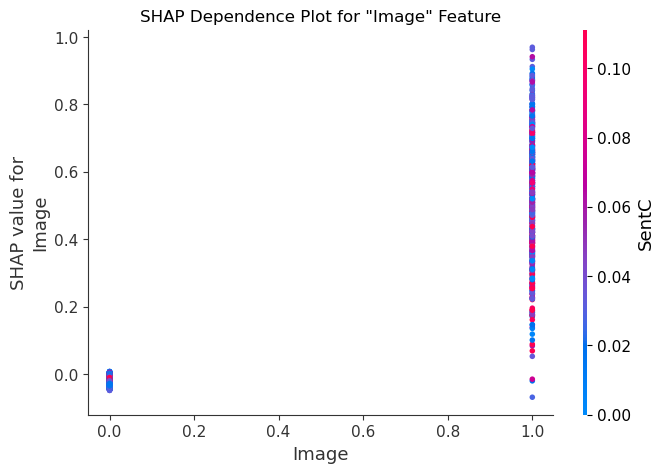

In [22]:
# Plot SHAP dependence plot for 'Image'
shap.dependence_plot('Image', shap_values, X_train_balanced, show=False)
plt.title('SHAP Dependence Plot for "Image" Feature')
plt.savefig('shap_dependence_plot_Image.png', dpi=300)
plt.show()

In [23]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

      features  average_shap_value
4        SentC            0.854524
0       RewExt            0.836954
7     ElapDays            0.442971
3        WordC            0.284142
1    Sentiment            0.185197
5        SentL            0.157252
13         FRE            0.083895
2   Subjective            0.080490
10       NounR            0.072664
11        AdjR            0.068319
12        AdvR            0.061471
9       VerPur            0.053518
8        Image            0.040963
6       TitleL            0.011956


[11:53:38] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


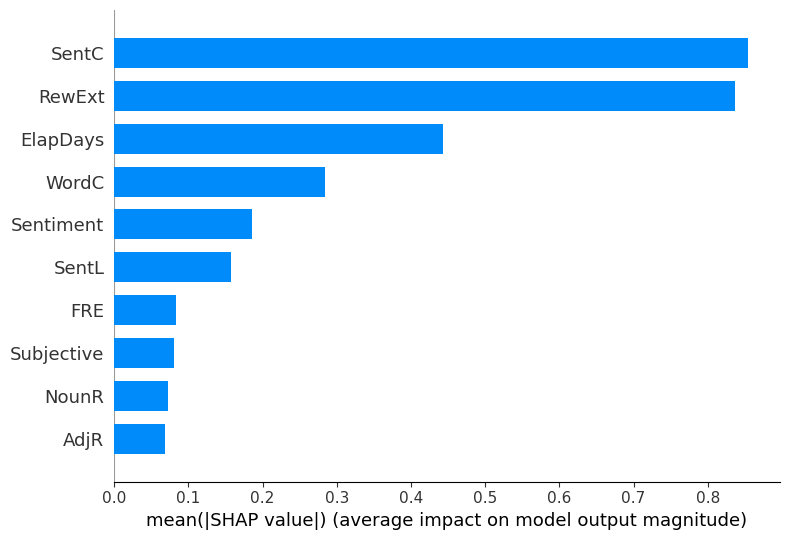

In [24]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True, max_display=10)



# 6. Testing on other Product


In [25]:
razor = pd.read_csv('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Old Data/UtiliRazor.csv')

# Create a new column 'helpful' based on reviews being helfpul or not helpful
razor['helpful'] = (razor['helpful_vote'] > 0).astype(int)

In [26]:
# Define features and target
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
                      'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']
target = 'helpful'



# Initialize X and y
X_razor = razor[features]
y_razor = razor[target]

# Initialize ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features)  # Scale numerical features
    ],
    remainder='passthrough'  # Keep all other columns in the DataFrame
)

# Fit and transform the data
X_razor_preprocessed = preprocessor.fit_transform(X_razor)

# Convert the transformed data back to a DataFrame
X_razor = pd.DataFrame(X_razor_preprocessed, columns=features)


In [27]:
# Perform train/test split
XR_train, XR_test, yR_train, yR_test = train_test_split(X_razor, y_razor, test_size=0.2, random_state=42)


In [28]:
# Predictions on test data
Ra_y_pred_opt = xgb_cls_default.predict(XR_test)

# Model evaluation
accuracy = accuracy_score(yR_test, Ra_y_pred_opt)
conf_matrix = confusion_matrix(yR_test, Ra_y_pred_opt)
cls_report = classification_report(yR_test, Ra_y_pred_opt)

print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(yR_test, Ra_y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(yR_test, Ra_y_pred_opt)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)



SMOTE-Hyp Model Evaluation:
Accuracy: 0.8089887640449438
F1 Score: 0.2980251346499102
AUC: 0.5851015127388535
Confusion Matrix:
[[1573  154]
 [ 237   83]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1727
           1       0.35      0.26      0.30       320

    accuracy                           0.81      2047
   macro avg       0.61      0.59      0.59      2047
weighted avg       0.79      0.81      0.80      2047

